In [2]:
!pip install pendulum
import pendulum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 3.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 490.0/490.0 kB 11.3 MB/s eta 0:00:00
  Created wheel for pendulum: filename=pendulum-2.1.2-cp310-cp310-manylinux_2_31_x86_64.whl size=168883 sha256=c3878ec9d85bbc11d995f3c385277307c860c18769227bb74bb23463cf2a4601
  Stored in directory: /root/.cache/pip/wheels/2e/41/ed/f113e4c9dc10f6c846d69f412e9cd9aa429960a3e2e485a4f9
Successfully built pendulum


# **Подготовка проекта**
В данном разделе описана подготовка проекта как на Google Colab так и на личном компьютере.
## ***Установка вирутального окружения***
Установка виртуального окружения для **Google Colab** не нужно. Установка вирутального окружения на личный комьютер требует открытия командной строки в корне проекта и создании и запуска самого вирутального окружения по [гайду](https://docs.python.org/3/library/venv.html).
## ***Установка зависимостей***
Для установки зависимостей в **Google Colab** единственное, что от вас необходимо это доустановить ***ipyplot*** в Colab через соответсвующий бокс с комментарием `# for google colab only`. Для установки на личный компьютер в корне проекта есть файл ***requirements.txt***, который вам необходим для установки всех нужных бибилиотек в ваше **виртуальное окружение**. Установить все зааввисимости разом можно с помощью команды `pip install -r /path/to/requirements.txt`.

In [ ]:
# for google colab only
# Если не работаете в google colab данный блок нужно пропустить или закомментировать
!pip install -qqq ipyplot

In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
from ipyplot import plot_images
import glob
import cv2
import torch
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, AveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
project_path = Path.cwd()
print(f'{project_path=}')

project_path=PosixPath('/content')


In [ ]:
# for google colab only
# Если не работаете в google colab данный блок нужно пропустить или закомментировать
from google.colab import drive
drive.mount('/content/drive')
# Если исспользуете colab нужно будет ввести путь вручную
project_path = Path('/content/drive/MyDrive/ИСИТ11')
print(f'{project_path=}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
project_path=PosixPath('/content/drive/MyDrive/ИСИТ11')


# **Подготовка данных**
В данном разделе описана подготовка обучающей и тестовой выборки. Каждая из выборок имеет внутри себя папку с фотографиями и файл ***csv*** для сверки классификации.


## ***Подготовка обучающей выборки***
Для обучения нейронной сети нам необходимо дать для нее обучающую выборку. В данном разделе мы выделим несколько **DataFrame**`ов в табличном представлении.

In [ ]:
train_path = project_path / 'train'
df_raw_train = pd.read_csv(train_path / 'train.csv')
print(len(df_raw_train))
df_raw_train

2131


,filename,blur
0,kagouracdzwrjjxzzedi.jpg,0.0
1,ahnamimqdfqoqdnozabc.jpg,0.0
2,gwhdadvghuzinmzhzssx.jpg,0.0
3,onqwabwwckubrydgbzly.jpg,0.0
4,ewpqdruddbokqyzzupcw.jpg,1.0
...,...,...
2126,uiapikbqzjeqnqwppsat.jpg,1.0
2127,usmpqmpgqaqkixiyxotp.jpg,1.0
2128,qwgctjomdbtvcwmwbasj.jpg,1.0
2129,egyieadlchhkrykqanwz.jpg,0.0


In [ ]:
df_train = df_raw_train.copy()
df_train['filename'] = df_train['filename'].apply(lambda x: str(train_path.absolute()) + '/train/' + x)
df_train.head()

,filename,blur
0,/content/drive/MyDrive/ИСИТ11/train/train/kago...,0.0
1,/content/drive/MyDrive/ИСИТ11/train/train/ahna...,0.0
2,/content/drive/MyDrive/ИСИТ11/train/train/gwhd...,0.0
3,/content/drive/MyDrive/ИСИТ11/train/train/onqw...,0.0
4,/content/drive/MyDrive/ИСИТ11/train/train/ewpq...,1.0


In [ ]:
train_blur = df_train[df_train["blur"]==1]
train_sharp = df_train[df_train["blur"]==0]

print("blur images:", len(train_blur))
print("sharp images:", len(train_sharp))

blur images: 1037
sharp images: 1094


### ***Просмотр обучающей выборки***
В данных блоках вы можете посмотреть несколько **четких** и несколько **размытых** фотографий *соответсвенно*.

In [ ]:
images = train_sharp.filename.sample(6).tolist()
print(images)
plot_images(images, max_images=10,img_width=220,force_b64=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = train_blur.filename.sample(6).tolist()
plot_images(images,max_images=10,img_width=220,force_b64=True)

Output hidden; open in https://colab.research.google.com to view.

## ***Подготовка тестовой выборки***
Для сверки результатов нейронной сети нам необходима тестовая выборка. В данном разделе мы выделим несколько **DataFrame**`ов в табличном представлении.

In [ ]:
test_path = project_path / 'test'
df_raw_test = pd.read_csv(test_path / 'test.csv')
print(len(df_raw_test))
df_raw_test

533


,filename,blur
0,ejjtvrhazazshfpuxiga.jpg,1.0
1,fvrwriifmwpoghyonqiq.jpg,1.0
2,qgeppailqsbyreabuabq.jpg,0.0
3,ohhepvgvfzbwlzunyleb.jpg,1.0
4,runzfbzjtsrencjrfztc.jpg,1.0
...,...,...
528,ekzzbhgxpjkbsxtxlbnc.jpg,0.0
529,meipbfwdswjbsrqgvavf.jpg,0.0
530,xemheyghqkjzsnmxdcxp.jpg,1.0
531,eewnxfiozkaozdphhcii.jpg,1.0


In [ ]:
df_test = df_raw_test.copy()
df_test['filename'] = df_test['filename'].apply(lambda x: str(test_path.absolute()) + '/test/' + x)
df_test.head()

,filename,blur
0,/content/drive/MyDrive/ИСИТ11/test/test/ejjtvr...,1.0
1,/content/drive/MyDrive/ИСИТ11/test/test/fvrwri...,1.0
2,/content/drive/MyDrive/ИСИТ11/test/test/qgeppa...,0.0
3,/content/drive/MyDrive/ИСИТ11/test/test/ohhepv...,1.0
4,/content/drive/MyDrive/ИСИТ11/test/test/runzfb...,1.0


In [ ]:
test_blur = df_test[df_test["blur"]==1]
test_sharp = df_test[df_test["blur"]==0]

print("blur images:", len(test_blur))
print("sharp images:", len(test_sharp))

blur images: 260
sharp images: 273


### ***Просмотр обучающей выборки***
В данных блоках вы можете посмотреть несколько **четких** и несколько **размытых** фотографий *соответсвенно*.

In [ ]:
images = test_sharp.filename.sample(6).tolist()
print(images)
plot_images(images, max_images=10,img_width=220,force_b64=True)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
images = test_blur.filename.sample(6).tolist()
plot_images(images,max_images=10,img_width=220,force_b64=True)

Output hidden; open in https://colab.research.google.com to view.

# **Решение проблемы без методов искусственного интеллекта**
В данном разделе описано отдельное решение без методов искусственного интеллекта для сравнения. Решение основано на преобразовании Фурье.


In [ ]:
def read_image_gray(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)


class CustomDatasetTrain(CustomDataset):
    def __init__(self, df, transform=None):
        super().__init__(df)
        self.transform = transform

    def __getitem__(self,idx):
        image = self.df.filename.iloc[idx]
        image = read_image_gray(image)
        if self.transform:
            image = self.transform(image)
        label = self.df.blur.iloc[idx]
        return {'image': image, 'label': label}


class CustomDatasetTest(CustomDataset):
    def __getitem__(self,idx):
        image = self.df.filename.iloc[idx]
        image = read_image_gray(image)
        return {'image': image}

In [ ]:
test_dataset = CustomDatasetTrain(df_test)

test_dataloader = DataLoader(
            dataset=test_dataset,
            batch_size=16,
            ),
test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb36e9f4400>,)

In [ ]:
def calc_fft_measure(gray_img, size=40):
    """ Определение заблюренности изображения с помощью Fourier transform:

    - Изображение переводится в частотный спектр с помощью fft, производится сдвиг начала координат и
    зануляется низкочастотный спектр.
    - Частотный спектр переводится обратно в изображение с помощью inverse fft.
    - Считается магнитуда, определяется уровень заблюренности картинки.
    Чем больше полученное значение, тем более размыто изображение
    """
    (n, h, w) = gray_img.shape
    (cx, cy) = (int(w / 2.0), int(h / 2.0))
    fft = np.fft.fft2(gray_img, axes=(1, 2))
    fftShift = np.fft.fftshift(fft, axes=(1, 2))

    fftShift[:, cy - size : cy + size, cx - size : cx + size] = 0
    fftShift = np.fft.ifftshift(fftShift, axes=(1, 2))
    recon = np.fft.ifft2(fftShift, axes=(1, 2))

    magnitude = 20 * np.log(np.abs(recon))
    mean = 1/np.average(magnitude, axis=(1, 2))

    return mean

In [ ]:
fft_measures = []

for dl in test_dataloader:
    # print(dl)
    for batch in tqdm(dl):
        fft_measures.extend(calc_fft_measure(batch['image']).tolist())

df_test['fft_measure'] = fft_measures

100%|██████████| 34/34 [00:23<00:00,  1.45it/s]


In [ ]:
print('ROC AUC using Total Variation:', np.round(roc_auc_score(df_test.blur.tolist(), df_test.fft_measure.tolist()), 5))

ROC AUC using Total Variation: 0.81398


### ***Заключение метода***
Как показала практика данный метод с примерной точностью в **80%** имеет место быть, но в данной работе мы постараемся выдать более сильный классификатор на основе нейронных сетей.

# **Решение проблемы на основе сверточных сетей**
В данном разделе описано решение классификации изображения на основе сверточных нейронных сетей.



## ***Подготовка датасетов***
Теперь нам необходимо соеденить знания о классификации изображения вместе с самими изображениями. Для этого используется [ImageDataGenerator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) из Keras. Данный генератор кроме создания датасета также аугментирует его по заданным параметрам, делая нашу выборку больше. Также стоит отметить, что в данном блоке кода кроме обучающей и тестовой выделяется валидационная выборка,
для более качественного обучения модели.

*P.S.* Как вариант можно в будущем заменить данное решение на более эффективный генератор.

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 20,
        zoom_range = 0.05,
        width_shift_range = 0.05,
        height_shift_range = 0.05,
        shear_range = 0.05,
        vertical_flip = True,
        horizontal_flip = True,
        fill_mode = "nearest",
        validation_split = 0.15)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

train_ds = train_datagen.flow_from_dataframe(
        df_train,
        directory=train_path / 'train',
        x_col='filename',
        y_col= 'blur',
        batch_size=64,
        shuffle=True,
        subset='training',
        class_mode='raw')

val_ds = train_datagen.flow_from_dataframe(
        df_train,
        directory=train_path / 'train',
        x_col='filename',
        y_col= 'blur',
        shuffle=True,
        batch_size=64,
        subset='validation',
        class_mode='raw')

test_ds = test_datagen.flow_from_dataframe(
        df_test,
        directory=test_path / 'test',
        x_col='filename',
        batch_size=1,
        class_mode=None,
        shuffle=False)

Found 1812 validated image filenames.
Found 319 validated image filenames.
Found 533 validated image filenames.


## ***Компиляция сверточной нейронной модели***
Для классификации изображений выбрана сверточная нейронная сеть **Keras**. Дополнительную информацию о ней можно прочитать [здесь](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

В данном блоке кода описывается кол-во нейронных слоев, а также их размерность. При редактировании данных гиперпараметров учтите, что чем больше на выходе связей, тем тяжелее нейронаая сеть.


In [ ]:
def auroc(y_true, y_pred):
    try:
        auroc = tf.py_function(roc_auc_score, (y_true, y_pred), tf.double)
    except ValueError:
        pass
    return auroc
metrics=['accuracy', auroc]

model = Sequential()
model.add(Conv2D(32, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())# model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())# model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())# model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())# model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(64, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='selu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0

## ***Обучение сверточной нейронной модели***
В данном блоке кода с помощью метода ***fit*** происхоит обучение модели на обучающей выборке и сравнение обучения на валидационной выборке. Для ускорения времени обучния добавлен метод ранней остановки или же [EarlyStopping](https://keras.io/api/callbacks/early_stopping/).

В данном блоке можно попробовать изменить ошибку остановки ***erloss*** или же именить параметры обучения и ранней остановки. Учтите, что чем больше эпох стоит при обучении тем дольше модель будет обучаться.

*P.S.* примерное время с данными настройками в Google Colab ***~40 минут***, на относительно среднем процессоре данный модуль выполняется за ***~15 минут***.

In [ ]:
erloss = 'val_loss' # 'val_accuracy' # 'val_auroc'
earlyStopping = EarlyStopping(monitor=erloss, patience=4, verbose=0, mode='min', restore_best_weights=True)

hist = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[earlyStopping])

Epoch 1/20
29/29 [==============================] - 552s 19s/step - loss: 0.6961 - accuracy: 0.5552 - auroc: 0.6180 - val_loss: 0.6821 - val_accuracy: 0.5799 - val_auroc: 0.7349
Epoch 2/20
29/29 [==============================] - 154s 5s/step - loss: 0.6279 - accuracy: 0.6821 - auroc: 0.7495 - val_loss: 0.5650 - val_accuracy: 0.7398 - val_auroc: 0.8246
Epoch 3/20
29/29 [==============================] - 156s 5s/step - loss: 0.5513 - accuracy: 0.7329 - auroc: 0.8206 - val_loss: 0.4902 - val_accuracy: 0.7680 - val_auroc: 0.8596
Epoch 4/20
29/29 [==============================] - 164s 6s/step - loss: 0.5234 - accuracy: 0.7666 - auroc: 0.8600 - val_loss: 0.4469 - val_accuracy: 0.7900 - val_auroc: 0.9051
Epoch 5/20
29/29 [==============================] - 155s 5s/step - loss: 0.4552 - accuracy: 0.7969 - auroc: 0.8942 - val_loss: 0.4569 - val_accuracy: 0.7712 - val_auroc: 0.9376
Epoch 6/20
29/29 [==============================] - 155s 5s/step - loss: 0.4064 - accuracy: 0.8273 - auroc: 0.9240

## ***Графический анализ обучения сверточной нейронной модели***
В данных блоках кода представлены графики обучения вашей модели. Чем более плавный переход имеют графики тем лучше.

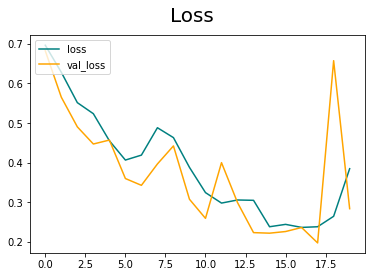

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

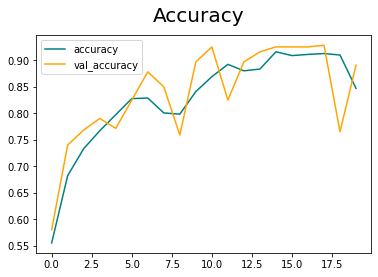

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## ***Получения предсказаний сверточной нейронной модели***
В данном блоке кода предскаываем тестовый датасет и сравниваем его с реальными данными.

In [ ]:
measures = model.predict(test_ds)
print(roc_auc_score(df_test['blur'], measures))

533/533 [==============================] - 14s 26ms/step
0.9438292476754016


### ***Заключение метода***
Как показала практика данный метод с примерной точностью в **94%** смог опередить метод предсказания на основе преобразования Фурье.